In [82]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle

In [83]:
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documents/GitHub/Photonics-training/Projects/MMI/Lumerical files')) #Current directory

#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 

In [84]:
mmi = lumapi.MODE(filename="MMIProject.lms") 

## Functions

In [ ]:
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

## Assembly parameters

In [ ]:
# Body config------------------------------------
BdX_Span = 31.87e-6; # Body X Span
BdY_Span = 6e-6; # Body y Span


# Ports config-----------------------------------

OutMx = [1.6e-6,-1.6e-6]; # Array of output ports y positions (put 0 on first element to ignore this line)
InMx = [0];               # Array of input ports y positions (put 0 on first element to ignore this line) 

# If the lines above has to be ignored, use these ones instead: 
InP = 1; # Number of Input ports
OutP = 2; # Number of Output ports
Asy = 0; # Force asymmetry on inputs ports auto-displacement (0 -> Symetry, 1 -> Asymmetry)
         
PYSpan_in = 12e-6; # Input Port Y Span 
PYSpan_out = 3e-6; # Output Port Y Span 


# Tappers config---------------------------------
SetToTappers = 1; # Set tappers as inputs/outputs
TLen = 4e-6; # Tapper Length
TWidth = 1e-6; # Tapper Width


# Mesh config------------------------------------
MeshEnable = 0; # 1 for enable mesh insertion


# EME config-------------------------------------
EME_MC = 100; # Number of EME Mesh Cells (Y and Z)
SideCells = 3; # Number of Cells on Input/Output groups

## Sweep parameters

In [ ]:
SPar = [2,3]; # Ports to analyse S parameters (SX1)

TapperSweep = 1; # Enable tappers width sweep
TSRange = [1.05e-6,1.4e-6]; # Tapper sweep range
TSPoints = 2; # Tapper sweep number of points

## Assembly

In [ ]:
# General & Body settings -----------------------------------

mmi.switchtolayout()
mmi.selectall()
mmi.delete()

TLen = TLen*SetToTappers

if InMx[0] != 0:
    InP = len(InMx)
if OutMx[0] != 0:
    OutP = len(OutMx)

RectInsert(BdX_Span/2,BdX_Span, 0,BdY_Span, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mmi)
mmi.set("name","MMI Body")

# Input/Output ports setting --------------------------------

for i in range(1,InP+1):
    if(InMx[0]==0):
        InY = (i/((Asy+1)*(InP+1))-0.5)*BdY_Span*(1-2*Asy)**i
    else:
        InY = InMx[i-1]
    RectInsert(-TLen-2e-6,4e-6 , InY,0.45e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi);
    mmi.set("name","MMI EnterPort "+ str(i))

for i in range(1,OutP+1):
    if(OutMx[0]==0):
        OutY = (i/(OutP+1)-0.5)*BdY_Span
    else:
        OutY = OutMx[i-1]
    RectInsert(BdX_Span+TLen+2e-6,4e-6, OutY,0.45e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi)
    mmi.set("name","MMI OutPort "+ str(i))


if(SetToTappers == 1):
    for i in range(1,InP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":180,
             "x":-TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth,  
             "angle_side":90,  
             "name":"Input Taper "+ str(i)})
        InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
        mmi.set("y",InY)
  
    for i in range(1,OutP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":0,
             "x":BdX_Span+TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "angle_side":90, 
             "name":"Output Taper "+ str(i)})
        OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
        mmi.set("y",OutY)


# EME setting ----------------------------------------------
mmi.addeme()

mmi.set({"allow custom eigensolver settings":1 ,"display cells":1, "number of cell groups":3,
         "group spans": np.transpose([(1.3*TLen+4e-6)/2, BdX_Span, (1.3*TLen+4e-6)/2]),
         "cells":np.transpose([SideCells, 1, SideCells]),
         "subcell method":np.transpose([1, 0, 0]), # 0 = none,  1 = CVCS
         "modes":np.transpose([10, 50, 10])})

mmi.set({"x min":(-1.3*TLen-4e-6)/2 ,
     "y":0, "y span":1.4*BdY_Span,
     "z":0, "z span":4e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "background material": "SiO2 (Glass) - Palik",
     "mesh cells y":EME_MC, "mesh cells z":EME_MC})


# EME Ports setting -----------------------------------------
mmi.selectpartial("EME::Ports::port")
mmi.delete()
for i in range(1,InP+1):
    mmi.addemeport()
    InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"left",
    "y":InY, "y span":PYSpan_in,
    "z":0, "z span":4e-6})
  
for i in range(1,OutP+1):
    mmi.addemeport()
    OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"right",
    "y":OutY, "y span":PYSpan_out,
    "z":0, "z span":4e-6})  



# Monitors setting ---------------------------------
mmi.addemeprofile()
mmi.set("x", BdX_Span/2)
mmi.set("x span", BdX_Span+1.3*TLen+4e-6)
mmi.set("y span", 1.4*BdY_Span)

    
# Mesh setting -------------------------------------
if(MeshEnable == 1):
    mmi.addmesh()
    mmi.set({"x":-2e-6, "x span":0,
        "y":0, "y span":BdY_Span,
        "z":0, "z span":4e-6})
    mmi.set("name","input_mesh")
    
    mmi.addmesh()
    mmi.set({"x":BdX_Span+2e-6, "x span":0,
        "y":0, "y span":BdY_Span,
        "z":0, "z span":4e-6})
    mmi.set("name","output_mesh")


## Sweeps

### Tapper length sweep

[[10]
 [ 2]]
[-10.  -5.   0.   5.  10.]
[[1]
 [3]
 [4]
 [5]
 [6]]
[[8]
 [6]
 [3]
 [2]
 [1]]


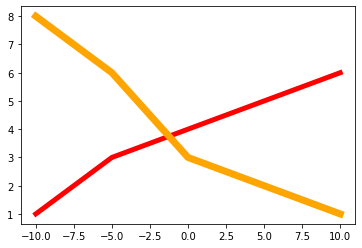

In [ ]:
A = [2,3,4,5]
B = np.matrix('1,10,100,1000 ; 1,2,3,4')

print(B[:,1])


x = np.linspace(-10, 10, 5)
y1 = np.matrix('1;3;4;5;6')
y2 = np.matrix('8;6;3;2;1')
print(x)
print(y1)
print(y2)

plt.plot(x, y1, color='red', lw=5)
plt.plot(x, y2, color='orange', lw=7)

In [ ]:
SParSz = len(SPar)
pMatrix = np.zeros((TSPoints,SParSz))
dMatrix = np.zeros((TSPoints,SParSz))
TRangeMatrix = np.linspace(TSRange[0],TSRange[1],TSPoints)

if(TapperSweep == 1):
    mmi.selectpartial("Output Taper")
    OutP = int(mmi.getnumber())
    print("Tapper width sweep in progress...")
    print("Number of output ports found: " + str(OutP))

    for i in range(TSPoints):
        text = "Progress: " + str(i+1) + "/" + str(TSPoints)
        print(text);   
        
        mmi.switchtolayout()
        for j in range(OutP):
            mmi.setnamed("Output Taper " +str(j+1),
            "width_l",TRangeMatrix[i])
        
        mmi.run()
        mmi.emepropagate()
        
        A = mmi.getresult("EME","user s matrix")
        print(abs(A)**2)
        for j in range(SParSz):
            print(abs(A[SPar[j]-1,0])**2)
            print('---------------------')
            pMatrix[i,j] = abs(A[SPar[j]-1,0])**2
            dMatrix[i,j] = 20*np.log10(abs(A[SPar[j]-1,0]))
    
    print('-.-.-.-.-.-.-')
    print(pMatrix)
    print('-.-.-.-.-.-.-')
    for i in range(SParSz):
        plt.plot(TRangeMatrix,pMatrix[:,i])
        print(TRangeMatrix)
        print(pMatrix[:,i])

    
    # mmi.closeall()
    # P = mmi.matrixdataset("S parameters in Abs^2")
    # D = mmi.matrixdataset("S parameters in dB")
    # P.addparameter("Tapper width",TRangeMatrix)
    # D.addparameter("Tapper width",TRangeMatrix) 
    # for i in range(SParSz):
    #     X = np.matrix(pMatrix[0:TSPoints, i])
    #     Y = np.matrix(dMatrix[0:TSPoints, i])
    #     mmi.P.addattribute("S"+str(SPar[i])+"1" ,X)
    #     mmi.D.addattribute("S"+str(SPar[i])+"1" ,Y)
    
    # mmi.visualize(P)
    # mmi.visualize(D)


LumApiError: 'Operation on closed application'